In [1]:
from pynq import PL
PL.reset() #important fixes caching issues which have popped up.
import xrfdc #poorly documented library that handles interfacing to the RF data converter
from pynq import Overlay  #import the overlay module
ol = Overlay('./design_1.bit')  #locate/point to the bit file
import pprint
pprint.pprint(ol.ip_dict)
dma = ol.axi_dma_0 #might need to change name depending on what you called it



{'axi_dma_0': {'addr_range': 65536,
               'bdtype': None,
               'device': <pynq.pl_server.embedded_device.EmbeddedDevice object at 0xffff9c251a80>,
               'driver': <class 'pynq.lib.dma.DMA'>,
               'fullpath': 'axi_dma_0',
               'gpio': {},
               'interrupts': {},
               'mem_id': 'S_AXI_LITE',
               'memtype': 'REGISTER',
               'parameters': {'ADDR_WIDTH': '10',
                              'ARUSER_WIDTH': '0',
                              'AWUSER_WIDTH': '0',
                              'BUSER_WIDTH': '0',
                              'CLK_DOMAIN': 'design_1_zynq_ultra_ps_e_0_0_pl_clk0',
                              'C_BASEADDR': '0xA0000000',
                              'C_DLYTMR_RESOLUTION': '125',
                              'C_ENABLE_MULTI_CHANNEL': '0',
                              'C_FAMILY': 'zynquplus',
                              'C_HIGHADDR': '0xA000FFFF',
                          

In [5]:
rf = ol.usp_rf_data_converter_0 #might need to change name depending on what you called it
adc_tile = rf.adc_tiles[2]
print(adc_tile)
adc_block = adc_tile.blocks[0]
print(adc_block)
print(adc_block.BlockStatus)
print(adc_block.MixerSettings)
adc_block.Dither = 0 #doesn't really matter for this lab, but let's turn off.
adc_block.MixerSettings['Freq']=-85 # set the frequency of the Numerically controlled oscillator.
adc_block.UpdateEvent(xrfdc.EVENT_MIXER) #every time setting is changed, must call this.
print(adc_block.MixerSettings)

{'SamplingFreq': 1.47456, 'AnalogDataPathStatus': 1, 'DigitalDataPathStatus': 929, 'DataPathClocksStatus': 1, 'IsFIFOFlagsEnabled': 3, 'IsFIFOFlagsAsserted': 0}
{'Freq': 0.0, 'PhaseOffset': 0.0, 'EventSource': 2, 'CoarseMixFreq': 16, 'MixerMode': 3, 'FineMixerScale': 0, 'MixerType': 2}
{'Freq': -84.99999999999943, 'PhaseOffset': 0.0, 'EventSource': 2, 'CoarseMixFreq': 0, 'MixerMode': 3, 'FineMixerScale': 0, 'MixerType': 2}


In [2]:
rf = ol.usp_rf_data_converter_0 #might need to change name depending on what you called it
dac_tile = rf.dac_tiles[0]
print(dac_tile)
dac_block = dac_tile.blocks[0]
print(dac_block)
print(dac_block.BlockStatus)
print(dac_block.MixerSettings)
dac_block.MixerSettings['Freq']=0 # set the frequency of the Numerically controlled oscillator.
dac_block.UpdateEvent(xrfdc.EVENT_MIXER) #every time setting is changed, must call this.
print(dac_block.MixerSettings)

{'SamplingFreq': 1.47456, 'AnalogDataPathStatus': 16, 'DigitalDataPathStatus': 8353, 'DataPathClocksStatus': 1, 'IsFIFOFlagsEnabled': 3, 'IsFIFOFlagsAsserted': 0}
{'Freq': 0.0, 'PhaseOffset': 0.0, 'EventSource': 2, 'CoarseMixFreq': 16, 'MixerMode': 2, 'FineMixerScale': 0, 'MixerType': 2}
{'Freq': 0.0, 'PhaseOffset': 0.0, 'EventSource': 2, 'CoarseMixFreq': 0, 'MixerMode': 2, 'FineMixerScale': 0, 'MixerType': 2}


Hardware execution time:  0.0012733936309814453


<IPython.core.display.Javascript object>


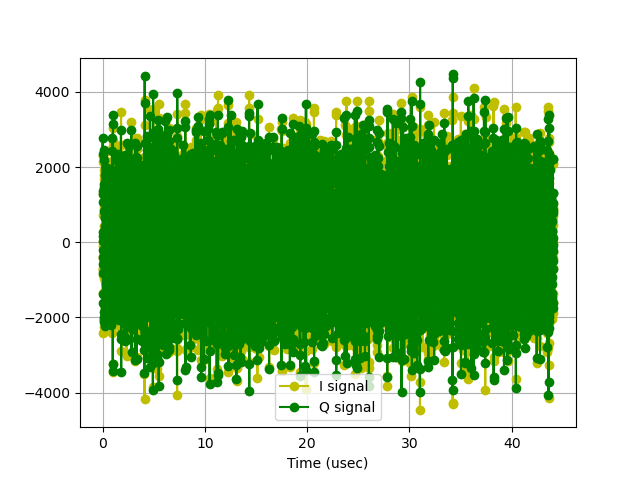

<IPython.core.display.Javascript object>


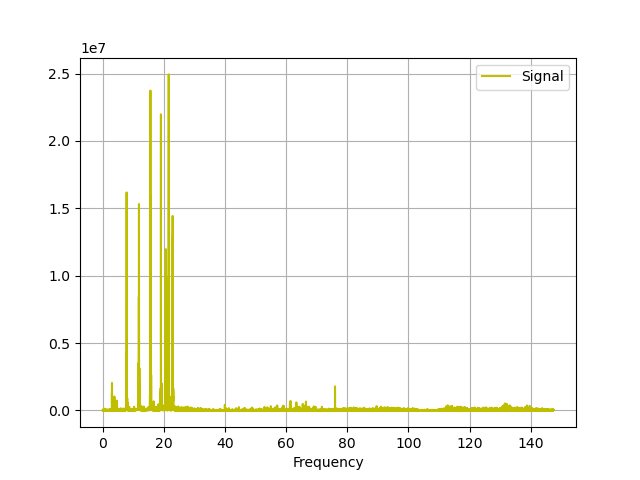

In [24]:
import numpy as np
import time
%matplotlib notebook
import matplotlib.pyplot as plt
from pynq import allocate

def plot_to_notebook(time_sec,in_signal,n_samples,):
    plt.figure()
    plt.subplot(1, 1, 1)
    plt.xlabel('Time (usec)')
    plt.grid()
    plt.plot(time_sec[:n_samples]*1e6,in_signal[:n_samples],'y-o',label='Input signal')
    #plt.plot(time_sec[:n_samples]*1e6,in_signal[:n_samples],'y-o',label='Input signal')

    plt.legend()
def iq_plot(time_sec,re_signal,im_signal,n_samples,):
    plt.figure()
    plt.subplot(1, 1, 1)
    plt.xlabel('Time (usec)')
    plt.grid()
    plt.plot(time_sec[:n_samples],re_signal[:n_samples],'y-o',label='I signal')
    plt.plot(time_sec[:n_samples],im_signal[:n_samples],'g-o',label='Q signal')
    #plt.plot(time_sec[:n_samples]*1e6,in_signal[:n_samples],'y-o',label='Input signal')

    plt.legend()

def plot_fft(samples,in_signal,n_samples,):
    plt.figure()
    plt.subplot(1, 1, 1)
    plt.xlabel('Frequency')
    plt.grid()
    plt.plot(samples[:n_samples],in_signal[:n_samples],'y-',label='Signal')
    #plt.plot(time_sec[:n_samples]*1e6,in_signal[:n_samples],'y-',label='Signal')
    plt.legend()

dma = ol.axi_dma_0 #might need to change name depending on what you called it

# Sampling frequency
#fs = 100
fs = 147.456
# Number of samples
n = 65536
T = n/fs

# Time vector in seconds
t = np.linspace(0, T, n, endpoint=False)
# Allocate buffers for the input and output signals
ns = np.linspace(0, fs,n,endpoint=False)

out_buffer = allocate(400024, dtype=np.int32)
# Trigger the DMA transfer and wait for the result
start_time = time.time()
dma.recvchannel.transfer(out_buffer)
dma.recvchannel.wait()
stop_time = time.time()
hw_exec_time = stop_time-start_time
print('Hardware execution time: ',hw_exec_time)

real = []
imag = []
#extract the two values (I and Q) from each 32 bit write from the hardware side.
for i in range(65536):
    val = out_buffer[i]&0xFFFF
    if val>=32768:
        real.append(np.int32(0xFFFF0000|val))
    else:
        real.append(val)
    imag.append((out_buffer[i]>>16))

# plot_to_notebook(t,real,6500)
# plot_to_notebook(t,imag,6500)
iq_plot(t,real,imag,6500)
#c_data = np.array(real) + 1j*np.array(imag)
c_data = np.array(imag) + 1j*np.array(real)
z = np.fft.fft(c_data,n)
#z = np.fft.fftshift(np.fft.fft(c_data,n))
plot_fft(ns,abs(z),65535)
out_buffer.close()